# Intro

We'll be providing the LLM with a Pubmed ID, eg '35020963', and then asking it for two words from the title of that document.

If it gets both words correct then we classify the PubMedID as 'known', 
if it gets both wrong then it is 'unknown', 
and if it gets one correct and one wrong then it is 'half-known'. 

As per Ferrando et al 2024, We ignore the half-known Pubmed ID's and seek the features for the known and unknown Pubmed ID's only.

In [126]:
from datasets import load_dataset
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

ds = load_dataset("openlifescienceai/Med-HALT", "IR_pmid2title")

[nltk_data] Downloading package punkt to /home/oliver/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/oliver/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### MedHALT "IR_pmid2title" example

In [127]:
ds['train'][0]

{'PMID': 35020963,
 'Title': 'The relationship between nitrous oxide sedation and psychosocial factors in the pediatric outpatient setting',
 'Authors': 'Moharrami M, Ali S, Dick BD, Moeinvaziri F, Amin M.',
 'First Author': 'Moharrami M',
 'DOI': '10.1111/pan.14395',
 'Publication Year': 2022,
 'Abstract': "BACKGROUND: Moderate sedation using nitrous oxide (N\nAIMS: This study aimed to examine pediatric dental patients' behaviors while undergoing N\nMETHODS: In this within-subject observational study, participants received 40% N\nRESULTS: In 80 children with a mean age of 7.2 (2.2) years, administration of N\nCONCLUSION: In children sedated with N",
 'url': 'https://ncbi.nlm.nih.gov/pubmed/35020963',
 'id': '96892a50-abbb-42a8-8ff2-93c406d593fe',
 'source_title': None,
 'source_abstract': None,
 'pubmed_data_type': 'real_data',
 'is_paper_exists': 'Yes'}

In [128]:
introduction_long = """You are an intelligent retrieval system that uses state-of-the-art natural language processing and 
information retrieval techniques to search for and fetch the title of a specific scientific article. 
You take Pubmed Research Paper PMID as input and retrieve two key words from the title of that scientific article by searching through your memory.
The keywords should be nouns or verbs, not prepositions or adjectives.

The response should be returned in JSON format with three keys 'key_word_1', 'key_word_2', 'is_unknown'
The values of key_word_1 and key_word_2 should be the two key words from the corresponding Pubmed Paper title. 
If the article is not found or the correct title is unknown, respond with 'Unknown' to indicate the absence of the requested information, don't try to make up an answer.
Hence, the value of is_unknown should be 'True' if the article is not found or the correct title is unknown, 'False' otherwise.
"""


In [129]:
introduction_short = """Do not discuss, simply give a keyword from the title of the Pubmed Research Paper which has PMID = 35020963"""

In [130]:
introduction_short = """Do not discuss, simply give a keyword from the title of the Pubmed Research Paper which has PMID = 25335925"""

In [131]:
ds['train'][2]

{'PMID': 25335925,
 'Title': 'Pwp1 is required for the differentiation potential of mouse embryonic stem cells through regulating Stat3 signaling',
 'Authors': 'Shen J, Jia W, Yu Y, Chen J, Cao X, Du Y, Zhang X, Zhu S, Chen W, Xi J, Wei T, Wang G, Yuan D, Duan T, Jiang C, Kang J.',
 'First Author': 'Shen J',
 'DOI': '10.1002/stem.1876',
 'Publication Year': 2015,
 'Abstract': 'Leukemia inhibitory factor/Stat3 signaling is critical for maintaining the self-renewal and differentiation potential of mouse embryonic stem cells (mESCs). However, the upstream effectors of this pathway have not been clearly defined. Here, we show that periodic tryptophan protein 1 (Pwp1), a WD-40 repeat-containing protein associated with histone H4 modification, is required for the exit of mESCs from the pluripotent state into all lineages. Knockdown (KD) of Pwp1 does not affect mESC proliferation, self-renewal, or apoptosis. However, KD of Pwp1 impairs the differentiation potential of mESCs both in vitro and 

The PMID of this and other articles was entered into GPT4o, Claude 3.5, Llama 3.1 405B and llama 8B.

NONE of these models knew any of the PMID's. The task of NER (named entity recognition) of PMID's is too difficult and cannot be used for our research.

Instead, we trun to the NCBI dataset, which focusses on Named Entity Recognition (NER) of diseases.


### Other datasets, NCBI

#### Dataset Card for NCBI Disease

[Available on Huggingface](https://huggingface.co/datasets/ncbi/ncbi_disease)

This dataset contains the disease name and concept annotations of the NCBI disease corpus, a collection of 793 PubMed abstracts fully annotated at the mention and concept level to serve as a research resource for the biomedical natural language processing community.

Instances of the dataset contain an array of tokens, ner_tags and an id. An example of an instance of the dataset:

{
  'tokens': ['Identification', 'of', 'APC2', ',', 'a', 'homologue', 'of', 'the', 'adenomatous', 'polyposis', 'coli', 'tumour', 'suppressor', '.'],
  'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0],
  'id': '0'
}

Data Fields
id: Sentence identifier.
tokens: Array of tokens composing a sentence.
ner_tags: Array of tags, where 0 indicates no disease mentioned, 1 signals the first token of a disease and 2 the subsequent disease tokens.

In [133]:
ds_ncbi = load_dataset("ncbi/ncbi_disease")
ds_ncbi_train = list(ds_ncbi['train'])
ds_ncbi_testi = list(ds_ncbi['test'])
ds_ncbi_valid = list(ds_ncbi['validation'])
print("Records in train dataset: ", len(ds_ncbi_train))
print("Records in test dataset: ", len(ds_ncbi_testi))
print("Records in val dataset: ", len(ds_ncbi_valid))

Records in train dataset:  5433
Records in test dataset:  941
Records in val dataset:  924


In [134]:
# view example
ds_ncbi_train[0]

{'id': '0',
 'tokens': ['Identification',
  'of',
  'APC2',
  ',',
  'a',
  'homologue',
  'of',
  'the',
  'adenomatous',
  'polyposis',
  'coli',
  'tumour',
  'suppressor',
  '.'],
 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]}

### How we use this Dataset for Entity Recognition

We process the data retinaing only those quotes with entity names which are at least 3 tokens long.
The ner_tags identify the entity's tokens in the quote.
Later we can mask the final two tokens of the entity name, to see if the LLM knows what they are.

Using the above example:
'Identification of APC2, a homologue of the adenomatous polyposis coli tumour suppressor .'

The entity is: "adenomatous polyposis coli tumour", as identified by the ner_tags.

To test the LLM's entity recognition we create a masked quote:
'Identification of APC2, a homologue of the adenomatous polyposis [Word A] [Word B] suppressor .'
Then ask the LLM for A and B, thus scoring those which it knows both words a 'known', no words as 'unknown' and one word as inbetween.
As per Ferrando et al.


In the following code chunk we filter the dataset to retain only those records with at least 3 entity tokens.


In [177]:
def filter_long_sequences(dataset, min_tokens=2):
    """
    Filter records containing disease mentions of at least min_tokens non-punctuation tokens 
    and add positions of the last two tokens in the final valid sequence.
    
    Args:
        dataset (list): List of dictionaries containing 'tokens' and 'ner_tags'
        min_tokens (int): Minimum number of non-punctuation tokens
        
    Returns:
        list: Filtered dataset with new 'final_positions' key for valid records
    """
    import string
    
    def is_punctuation(token):
        """Helper function to check if a token consists only of punctuation."""
        return all(char in string.punctuation for char in token)
    
    filtered_dataset = []
    
    for record in dataset:
        tokens = record['tokens']
        ner_tags = record['ner_tags']
        current_sequence = []
        sequences = []
        
        # Find all non-zero sequences
        for i, (token, tag) in enumerate(zip(tokens, ner_tags)):
            if tag != 0:
                current_sequence.append(i)
                # If we have enough positions, check if we have at least min_tokens non-punctuation tokens
                if len(current_sequence) >= min_tokens:
                    non_punct_count = sum(1 for pos in current_sequence 
                                        if not is_punctuation(tokens[pos]))
                    if non_punct_count >= min_tokens and current_sequence not in sequences:
                        sequences.append(current_sequence.copy())
            elif current_sequence:
                current_sequence = []
                
        # Handle sequence that might end at the last position
        if current_sequence:
            non_punct_count = sum(1 for pos in current_sequence 
                                if not is_punctuation(tokens[pos]))
            if non_punct_count >= min_tokens and current_sequence not in sequences:
                sequences.append(current_sequence)
            
        # If we found any valid sequences
        if sequences:
            # Get the last valid sequence
            final_sequence = sequences[-1]
            
            # Create new record with final positions
            new_record = record.copy()
            new_record['final_positions'] = final_sequence[-2:]
            filtered_dataset.append(new_record)
            
    return filtered_dataset

Let's examine an example:

In [179]:
ds_ncbi_train_filtered = filter_long_sequences(ds_ncbi_train)
print("Len of train dataset:\n ", len(ds_ncbi_train_filtered))

ds_ncbi_testi_filtered = filter_long_sequences(ds_ncbi_testi)
print("Len of test dataset:\n ", len(ds_ncbi_testi_filtered))

ds_ncbi_valid_filtered = filter_long_sequences(ds_ncbi_valid)
print("Len of validation dataset:\n ", len(ds_ncbi_valid_filtered))

print("\nExample:\n",ds_ncbi_train_filtered[0])

Len of train dataset:
  1964
Len of test dataset:
  368
Len of validation dataset:
  366

Example:
 {'id': '25', 'tokens': ['These', 'intersex', 'differences', 'in', 'colorectal', 'cancer', 'risks', 'have', 'implications', 'for', 'screening', 'programmes', 'and', 'for', 'attempts', 'to', 'identify', 'colorectal', 'cancer', 'susceptibility', 'modifiers', '.'], 'ner_tags': [0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0], 'final_positions': [17, 18]}


In [137]:
# Test is somewhat small and we don't need validation dataset, so we'll add validation to test.

ds_ncbi_testi_filtered = ds_ncbi_testi_filtered + ds_ncbi_valid_filtered

Now we create a function which masks the last two words of the disease name (both words if there are only two)
We will present this to the LLM and ask it to give use the masked words.
Two correct words will count as a 'known entity', two incorrect words will count as an 'unknown entity'.
Inbetween will count as a 'half-known entity' nd be dismissed form the analysis, as per Ferrando et al.

In [144]:
def process_disease_record(record):
    """
    Process a disease record to create a masked sentence and extract relevant information.
    Skips punctuation when selecting tokens to mask.
    
    Args:
        record (dict): Dictionary containing 'tokens', 'ner_tags', and 'final_positions'
        
    Returns:
        tuple: (query_sentence, missing_words, disease_name)
            - query_sentence: string with masked words
            - missing_words: dict of masked words
            - disease_name: complete disease mention
            Returns empty strings if valid masking not possible.
    """
    id = record['id']
    tokens = record['tokens'].copy()
    positions = record['final_positions']
    
    def is_punctuation(token):
        return token in {',', '.', ':', ';', '!', '?', '-', '(', ')', '[', ']', '"', "'"}
    
    # Find valid positions for masking (non-punctuation)
    valid_positions = []
    current_pos = positions[0]
    
    # Try to find first valid position
    while current_pos < len(tokens) and len(valid_positions) < 1:
        if not is_punctuation(tokens[current_pos]):
            valid_positions.append(current_pos)
        current_pos += 1
    
    # Try to find second valid position, starting from the next token after first valid position
    if valid_positions:
        current_pos = valid_positions[0] + 1
        while current_pos < len(tokens) and len(valid_positions) < 2:
            if not is_punctuation(tokens[current_pos]):
                valid_positions.append(current_pos)
            current_pos += 1
    
    # If we couldn't find two valid positions, return empty results
    if len(valid_positions) != 2:
        return {'id': id, 'query': '', 'missing_words': ['', ''], 'entity_name': ''}
    
    # Store the missing words before masking
    missing_words = [
        tokens[valid_positions[0]],
        tokens[valid_positions[1]]
    ]
    
    # Replace tokens with placeholders
    tokens[valid_positions[0]] = '[Word A]'
    tokens[valid_positions[1]] = '[Word B]'
    query = ' '.join(tokens)
    
    # Extract the complete disease name
    ner_tags = record['ner_tags']
    disease_tokens = []
    in_sequence = False
    current_sequence = []
    
    # Find the sequence containing the valid positions
    for i, (token, tag) in enumerate(zip(record['tokens'], ner_tags)):
        if tag != 0:
            in_sequence = True
            current_sequence.append(token)
        elif in_sequence:
            if valid_positions[1] in range(i - len(current_sequence), i):
                disease_tokens = current_sequence
            current_sequence = []
            in_sequence = False
            
    # Handle sequence at the end of the text
    if in_sequence and valid_positions[1] in range(len(ner_tags) - len(current_sequence), len(ner_tags)):
        disease_tokens = current_sequence
        
    entity_name = ' '.join(disease_tokens)
    
    return {'id':id, 'query':query, 'missing_words': missing_words, 'entity_name':entity_name}

In [145]:
ds_ncbi_train_processed = []
ds_ncbi_testi_processed = []

for record in ds_ncbi_train_filtered:
    record_processed = process_disease_record(record)
    if record_processed['missing_words'] != ['', '']:
        ds_ncbi_train_processed.append(record_processed)
print("Len of train dataset:\n ", len(ds_ncbi_train_processed))

for record in ds_ncbi_testi_filtered:
    record_processed = process_disease_record(record)
    if record_processed['missing_words'] != ['', '']:
        ds_ncbi_testi_processed.append(record_processed)
print("Len of test dataset:\n ", len(ds_ncbi_testi_processed))

print("\nExample:\n",ds_ncbi_train_processed[12])

Len of train dataset:
  1942
Len of test dataset:
  725

Example:
 {'id': '25', 'query': 'These intersex differences in colorectal cancer risks have implications for screening programmes and for attempts to identify [Word A] [Word B] susceptibility modifiers .', 'missing_words': ['colorectal', 'cancer'], 'entity_name': 'colorectal cancer'}


We ask the LLM to nominate the missing words like this:

"""
Without discussion give the two missing words from this sentence; [Word A] and [Word B] as a python list: 

"RESULTS A statistically significant excess risk of cancer was seen among the patients with CHH ( standardized incidence ratio 6 . 9 , 95 % confidence interval 2 . 3 to 16 ) , which was mainly attributable to non - [Word A] [Word B] ( standardized incidence ratio 90 , 95 % confidence interval 18 to 264 ) ."

"""

The LLM then responds:
"""
["Hodgkin", "lymphoma"]
"""

We then execute a function to score the response against expected missing words for the disease (i.e. entity), ["Hodgkins", "lymphoma"]
Note, additional 's', but this is close enough, we use a fuzzy match and we ignore order. 
The score is the number of correct missing words, 0, 1 or 2.

A score of 2 will denote that the LLM knows the entity
A score of 0 will denote that the LLM does not know the entity
Records scoring 1 will be removed from further analysis

NOTE

This is inverted to the approach taken by Ferrando et al. They presented the entity to the LLM and asked for two attributes to discover whether the entity is known or unknown. Whereas we present attributes and ask for the indicated entity.

This inverted approach has been taken because medical entities (i.e diseases) are complex with many attributes, a large number of which are shared with other entities (diseases). It is a combination of attributes which indicates a single entity (disease).

Most medical datasets are in the form of context (i.e. attributes) from which we are asked to propose an entity. This is how the data is useful to medical professionals, so this is the approach we take here.

Therefore, we have assumed that the graph of the LLM's knowledge can be read in either direction along each edge. From attributes to entity, or from entity to attributes.

This makes our work interestingly different from Ferrando et al.

In [52]:
def score_llm_response(llm_response, expected_words, missing_qty=2):
    """
    Score LLM response against expected words using flexible matching rules.
    
    Args:
        llm_response (str): String containing one or two words in any format
        expected_words (list): List of expected words (one or two)
        missing_qty (int): Number of words expected (1 or 2)
        
    Returns:
        int: Score (0, 1, or 2 for missing_qty=2; 0 or 1 for missing_qty=1) based on number of correct matches
    """
    def clean_word(word):
        """Convert to singular form and lowercase"""
        lemmatizer = WordNetLemmatizer()
        
        word = word.lower().strip()
        word = word.strip('"\'[](),.')  # Remove common punctuation
        
        word = lemmatizer.lemmatize(word, 'n')
        return word
    
    def words_match(word1, word2):
        """Check if words approximately match using sequence matcher"""
        word1 = clean_word(word1)
        word2 = clean_word(word2)
        
        ratio = SequenceMatcher(None, word1, word2).ratio()
        return ratio > 0.85  # Threshold for approximate matching
    
    def extract_words(llm_response, missing_qty):
        """Extract first two words from first sequence in various input formats"""
        # Split on common sequence separators like 'or', 'and', newlines
        sequences = re.split(r'\s+or\s+|\s+and\s+|\n', llm_response, flags=re.IGNORECASE)
        
        # Take only the first sequence
        first_sequence = sequences[0]
        
        # Remove any brackets, quotes, etc.
        first_sequence = re.sub(r'[\[\]\'"{},]', ' ', first_sequence)
        
        # Split on whitespace and filter out empty strings
        words = [word.strip() for word in first_sequence.split() if word.strip()]
        
        # Take first two non-empty words
        return words[:missing_qty]
    
    try:
        # Validate missing_qty parameter
        if missing_qty not in [1, 2]:
            raise ValueError("missing_qty must be either 1 or 2")
            
        # Validate expected_words length matches missing_qty
        if len(expected_words) != missing_qty:
            raise ValueError(f"Expected {missing_qty} words but got {len(expected_words)} words")
        
        # Extract words from response string
        llm_words = extract_words(llm_response, missing_qty)
        
        if len(llm_words) < missing_qty:
            return 0  # Not enough words provided
            
        # Count matches (allowing for either order)
        matches = 0
        used_expected = set()
        used_llm = set()
        
        # Look for matches in any order
        for i, llm_word in enumerate(llm_words):
            for j, expected_word in enumerate(expected_words):
                if j not in used_expected and i not in used_llm:
                    if words_match(llm_word, expected_word):
                        matches += 1
                        used_expected.add(j)
                        used_llm.add(i)
                        break
        
        return matches
        
    except Exception as e:
        print(f"Error processing response: {e}")
        return 0

Let's use our code on real examples.

In [23]:
import goodfire
import os

api_key ='REDACTED'
client = goodfire.Client(api_key)


In [24]:
TOGETHER_API_KEY = 'REDACTED'

In [75]:
from tqdm import tqdm
from together import Together
import time

def query_to_llm(ds_ncbi_processed, provider="goodfire", missing_qty = 2):
    
    # Get data
    ds_ncbi_completed = []
    client_gf = goodfire.Client(api_key)
    client_tg = Together(api_key=TOGETHER_API_KEY)

    # loop over the data with tqdm progress bar
    for record in tqdm(ds_ncbi_processed, desc="Processing records"):
    
        # Create query with instructions to LLM
        if missing_qty == 2:
            instruction = "Without preamble, give the two missing words as indicated by [Word A] and [Word B] in the following sentence. Return your answer as a python list:\n "
        elif missing_qty == 1:
            instruction = "Without preamble, give the missing word as indicated by [Word A] in the following sentence. Return your answer as a python list:\n "
        else:
            print("No such quantity of missing words")
            return
            
        query = instruction + record['query']

        if provider == 'goodfire':
            
            # Simple rate limiting
            time.sleep(1.5)

            # Create a non-streaming completion using Goodfire
            response = client_gf.chat.completions.create(
                messages=[{"role": "user", "content": query}],
                model="meta-llama/Meta-Llama-3.1-8B-Instruct", # "meta-llama/Llama-3.3-70B-Instruct", "meta-llama/Meta-Llama-3.1-8B-Instruct"
            )
            llm_response = response.choices[0].message["content"]

        else:
            # call Together.ai

            try:
                response = client_tg.chat.completions.create(
                    model="meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo",
                    messages=[{"role": "user", "content": query}],
                    temperature=0.0,
                )
                llm_response = response.choices[0].message.content

            except Exception as e:
                llm_response = ''
                print(e)

        # Score LLM response
        score = score_llm_response(llm_response, expected_words=record['missing_words'], missing_qty=missing_qty)

        # Save results
        record['llm_response'] = llm_response
        record['score'] = score
        ds_ncbi_completed.append(record)

    return ds_ncbi_completed

In [174]:
ds_ncbi_train_completed_tg = query_to_llm(ds_ncbi_train_processed, provider='together')

# Scores:
Score_2 = sum(1 for d in ds_ncbi_train_completed_tg if d['score'] == 2)
Score_1 = sum(1 for d in ds_ncbi_train_completed_tg if d['score'] == 1)
Score_0 = sum(1 for d in ds_ncbi_train_completed_tg if d['score'] == 0)

print("In the TRAIN data we have:")
print("Known Entities    :", Score_2)
print("Uncertain Entities:", Score_1)
print("Unknown Entities  :", Score_0)

Processing records: 100%|██████████| 1942/1942 [20:25<00:00,  1.58it/s]

In the TRAIN data we have:
Known Entities    : 225
Uncertain Entities: 529
Unknown Entities  : 1188


In [191]:
import pandas as pd

# save progress with together.ai
pd.DataFrame(ds_ncbi_train_completed_tg).to_parquet('../classifier/data_classifier/ds_ncbi_train_completed_tg.parquet')

In [ ]:
ds_ncbi_train_completed_gf = query_to_llm(ds_ncbi_train_processed, provider='goodfire')

# Scores:
Score_2 = sum(1 for d in ds_ncbi_train_completed_gf if d['score'] == 2)
Score_1 = sum(1 for d in ds_ncbi_train_completed_gf if d['score'] == 1)
Score_0 = sum(1 for d in ds_ncbi_train_completed_gf if d['score'] == 0)

print("In the TRAIN data we have:")
print("Known Entities    :", Score_2)
print("Uncertain Entities:", Score_1)
print("Unknown Entities  :", Score_0)

In [ ]:
# save progress with goodfire
pd.DataFrame(ds_ncbi_train_completed_gf.to_parquet('../classifier/data_classifier/ds_ncbi_train_completed_gf.parquet')

In [192]:
ds_ncbi_testi_completed_tg = query_to_llm(ds_ncbi_testi_processed, provider='together')

# Scores:
Score_2 = sum(1 for d in ds_ncbi_testi_completed_tg if d['score'] == 2)
Score_1 = sum(1 for d in ds_ncbi_testi_completed_tg if d['score'] == 1)
Score_0 = sum(1 for d in ds_ncbi_testi_completed_tg if d['score'] == 0)

print("In the TEST data we have:")
print("Known Entities    :", Score_2)
print("Uncertain Entities:", Score_1)
print("Unknown Entities  :", Score_0)

Processing records: 100%|██████████| 725/725 [03:05<00:00,  3.90it/s]

In the TEST data we have:
Known Entities    : 81
Uncertain Entities: 227
Unknown Entities  : 417


In [193]:
# save progress
pd.DataFrame(ds_ncbi_testi_completed_tg).to_parquet('../classifier/data_classifier/ds_ncbi_testi_completed_tg.parquet')

## Next Day

In [11]:
# load from file
import pandas as pd
import goodfire
import os

api_key ='REDACTED'
client_gf = goodfire.Client(api_key)
variant = "meta-llama/Meta-Llama-3.1-8B-Instruct"

# load from file
ds_ncbi_train_completed_tg = pd.read_parquet('../classifier/data_classifier/ds_ncbi_train_completed_tg.parquet')
ds_ncbi_testi_completed_tg = pd.read_parquet('../classifier/data_classifier/ds_ncbi_testi_completed_tg.parquet')

# return to format previously used, not pandas, list of dicts
ds_ncbi_train_completed_tg = ds_ncbi_train_completed_tg.to_dict('records')
ds_ncbi_testi_completed_tg = ds_ncbi_testi_completed_tg.to_dict('records')


In [ ]:

# load from file
ds_ncbi_train_completed_tg = pd.read_parquet('../classifier/data_classifier/ds_ncbi_train_completed_tg.parquet')
ds_ncbi_testi_completed_tg = pd.read_parquet('../classifier/data_classifier/ds_ncbi_testi_completed_tg.parquet')

# return to format previously used, not pandas, list of dicts
ds_ncbi_train_completed_tg = ds_ncbi_train_completed_tg.to_dict('records')
ds_ncbi_testi_completed_tg = ds_ncbi_testi_completed_tg.to_dict('records')


## Beware the Contrastive Trick

In the contrastive trick we subtract the feature activiations of a 'known' entity from the feature activations of an unknown entity. We can sum or average the differences over a batch of such pairs, getting the most different features between each set. Negative features are those which indicate hallucination, positive features indicate non-hallucination.We can repeat this batched process over the entire data set and union the resulting features from each batch into a single distinct list of feature differences.

BUT

As per Ferrando et al, we want the features which are activated almost exclusively in one condition (known vs. unknown) but rarely or  never activate in the other condition. We are interested in exclusivity not scale.

Simply summing the per-batch differences in activations is not well-suited to detecting exclusive features. Summation over subsets will highlight features that have large aggregate differences. This will include the exclusive features we seek, but will not isolate them. We wont know which if the differing features are alsmost exclusive to one class or other.

So

We follow the approach by Ferrando et al, see p4 of 'Do I know this entity?': 

```
For each latent, we obtain the fraction of the time that it is active (i.e. has a value greater than zero) on known and unknown entities respectively...Then, we take the difference, obtaining the latent separation scores
```

In order to achieve this, we need to get the activated features from each and every prompt, we can't use the contrastive trick as per above.

In [207]:
from tqdm import tqdm
import time

def get_feature_activations(client, variant, entity_names, k=50):
    """
    Simple synchronous version that processes one example at a time
    """
    feature_activations = []
    feature_library = set()

    for entity_name in tqdm(entity_names, desc="Processing entity_names"):
        try:
            inspector = client.features.inspect(
                [{"role": "user", "content": entity_name}],
                model=variant,
                #features=features
            )

            #  prepare to collect activated features
            entity_features=[]

            for activation in inspector.top(k=k):

                # keep our own library of all unique features and their id's
                feature_library.add((activation.feature.uuid, activation.feature.label))

                # record the feature id and its activation value for this entity 
                entity_features.append({'uuid':activation.feature.uuid, 'activation':activation.activation})

            feature_activations.append({'entity_name': entity_name, 'entity_features': entity_features})
            time.sleep(0.5)  # Simple rate limiting

        except Exception as e:
            print(f"Failed to process example: {str(e)}")
            continue
            
    return feature_activations, feature_library

In [9]:
# The known and unknown entities are as follows:

entities_known   = [key['entity_name'] for key in ds_ncbi_testi_completed_tg if key['score'] == 2]
print("No. of known entities = ", len(entities_known))

entities_unknown = [key['entity_name'] for key in ds_ncbi_testi_completed_tg if key['score'] == 0]
print("No. of unknown entities = ", len(entities_unknown))

No. of known entities =  81
No. of unknown entities =  417


In [12]:
# Get the activations for the known and unknown entities

feature_activations_known,   feature_library_known   = get_feature_activations(client_gf, variant, entities_known,   k=100)
feature_activations_unknown, feature_library_unknown = get_feature_activations(client_gf, variant, entities_unknown, k=100)

Processing entity_names:   0%|          | 0/81 [00:00<?, ?it/s]

Processing entity_names: 100%|██████████| 417/417 [17:18<00:00,  2.49s/it]


So, we have two datasets in python, each is a list of records. 
The first list is for 'known' entities and the second list is for 'unknown' entities.
Below is an example record: 

```
{'entity_name': 'breast and ovarian cancer',
 'entity_features': [
  {'uuid': UUID('cd092e67-147c-4e1d-92ab-4c5011e15cd1'), 'activation': 3},
  {'uuid': UUID('5e4deda8-16c3-4306-851d-e3c92f45b874'), 'activation': 3},
  {'uuid': UUID('c4e5975c-4fd7-4726-af27-b14180f03672'), 'activation': 3},
  {'uuid': UUID('c1d7b972-3e06-4db3-8a2e-d7e586dc413f'), 'activation': 2},
  {'uuid': UUID('eb51f833-8faa-485b-9ae8-0eda6dbc430b'), 'activation': 2},
  {'uuid': UUID('ae37912a-ff49-4e1d-bea5-c0d057190475'), 'activation': 2},
  {'uuid': UUID('08431659-4dec-4ea4-9637-f1ab4e2e51f8'), 'activation': 2},
  ...
  ]}
```

The uuid's are the unique id's of features in the sparse autoencoder. The activation value is the extent to which that feature was activated by the entity_name. Not the entire query, we sought features for the entity_name alone.

There are up to a 100 such feature uuid's and their activations per entity_name. The features list is typically DIFFERENT for each entity_name. 

We may find that some entity names appear in both lists. So we need to select the UNIQUE known and unknown entities first.

Then, as per Ferrando et al, we need a function to : 
a) obtain the fraction of records for which each feature is active on known and unknown entities respectively.
b) calculate the difference in number of occurences, thus obtaining a 'separation score' for each feature.

BEWARE, there are many more records in the 'unknown' entities list than in the 'known' entities list. 
We want to use the information we have to the fullest, but need fair comparisons.

In [76]:
# Fucntion to help select the unique known and unknown entities

def filter_duplicate_entities(known_list, unknown_list):
    # Create sets of entity names from both lists
    known_names = {record['entity_name'] for record in known_list}
    unknown_names = {record['entity_name'] for record in unknown_list}
    
    # Find duplicate names that appear in both lists
    duplicate_names = known_names.intersection(unknown_names)
    
    # Filter out records with duplicate names from both lists
    filtered_known = [record for record in known_list 
                     if record['entity_name'] not in duplicate_names]
    filtered_unknown = [record for record in unknown_list 
                       if record['entity_name'] not in duplicate_names]
    
    return filtered_known, filtered_unknown

In [77]:
feature_activations_known_uq, feature_activations_unknown_uq = filter_duplicate_entities(feature_activations_known, feature_activations_unknown)

print("Len of unique known entites: ", len(feature_activations_known_uq))
print("Len of unique unknown entites: ", len(feature_activations_unknown_uq))

Len of unique known entites:  40
Len of unique unknown entites:  355


In [18]:
from collections import defaultdict
from typing import List, Dict, Set, Tuple
from uuid import UUID

def analyze_feature_separation(
    feature_activations_known: List[Dict],
    feature_activations_unknown: List[Dict],
    feature_library_known: Set[Tuple[UUID, str]],
    feature_library_unknown: Set[Tuple[UUID, str]]
) -> List[Tuple[str, float, float, float]]:
    """
    Analyzes feature activation patterns between known and unknown entities.
    
    Returns list of tuples: (feature_label, known_fraction, unknown_fraction, separation_score)
    sorted by absolute separation score (highest to lowest)
    """
    # Convert feature libraries to dict for easier lookup
    known_labels = dict(feature_library_known)
    unknown_labels = dict(feature_library_unknown)
    
    # Count feature occurrences
    known_counts = defaultdict(int)
    unknown_counts = defaultdict(int)
    
    # Count total records
    n_known = len(feature_activations_known)
    n_unknown = len(feature_activations_unknown)
    
    # Count feature occurrences in known entities
    for record in feature_activations_known:
        for feature in record['entity_features']:
            known_counts[feature['uuid']] += 1
            
    # Count feature occurrences in unknown entities
    for record in feature_activations_unknown:
        for feature in record['entity_features']:
            unknown_counts[feature['uuid']] += 1
    
    # Get all unique features
    all_features = set(known_counts.keys()) | set(unknown_counts.keys())
    
    # Calculate fractions and separation scores
    results = []
    for feature_id in all_features:
        # Get feature label
        label = known_labels.get(feature_id) or unknown_labels.get(feature_id) or str(feature_id)
        
        # Calculate fractions
        known_fraction = known_counts[feature_id] / n_known if n_known > 0 else 0
        unknown_fraction = unknown_counts[feature_id] / n_unknown if n_unknown > 0 else 0
        
        # Calculate separation score (difference in occurrence rates)
        separation_score = known_fraction - unknown_fraction
        
        results.append((label, feature_id, known_fraction, unknown_fraction, separation_score))
    
    # Sort by absolute separation score (highest to lowest)
    results.sort(key=lambda x: abs(x[3]), reverse=True)
    
    return results

In [93]:
# use the function
results = analyze_feature_separation(
    feature_activations_known_uq,
    feature_activations_unknown_uq,
    feature_library_known,
    feature_library_unknown
)

# Convert to pandas for presentation
feature_separations = pd.DataFrame(results)
feature_separations.columns = ['label', 'feature_id', 'known_frac', 'unknown_frac', 'sep_score' ]
pd.set_option('display.max_colwidth', None)

# view in order of features most exclusive to unknown entities (-ve separation scores)
feature_separations.sort_values('sep_score', ascending=True).head(25)

label  \
46               Syntactical special characters and delimiters in programming contexts   
47                                                                           feature_0   
35                        Variable assignments and value retrievals in calculator code   
48                The Russian word состав (composition/compilation) and its variations   
37                                     Birth dates in biographical/historical contexts   
51                     Syntactical markers that introduce descriptions or explanations   
43                       Syntactical elements in programming code and database queries   
52                   Structural elements for creating detailed multi-part explanations   
45                           Discussion of limited or scarce resources and constraints   
55                                   Format conversion operators in API and task names   
61                                   Formal corporate description boilerplate language   
59                                                                           feature_8   
63                                         Outline hierarchy level punctuation markers   
66  Discussions of optimal spatial arrangement and positioning of technical components   
57                                              The user needs technical clarification   
31                                       End of current speaker's turn in conversation   
32     The user is requesting code explanation or implementation, especially in Python   
69                                                             The user has a question   
40                                                       The user has asked a question   
70        Offensive request from the user instructing AI to bypass ethical constraints   
72     The character sequence 'pet' regardless of semantic meaning or language context   
76                                      The model is analyzing or processing questions   
86                   Syntactic delimiters and formatting characters in structured text   
91                                    Structured data parsing and classification tasks   
82              The assistant is politely offering help using formal language patterns   

                              feature_id  known_frac  unknown_frac  sep_score  
46  16ba158a-4dda-4b5f-a58f-64c26d26e804       0.050      0.456338  -0.406338  
47  1057541e-c829-400a-a14b-a0e777118869       0.050      0.445070  -0.395070  
35  62d75912-9f40-45b3-8a5d-19e966f5a7af       0.125      0.507042  -0.382042  
48  555d3f44-674b-4027-80eb-3a0182d388f8       0.050      0.419718  -0.369718  
37  9a449812-dd0e-47bb-9d4c-602c3c7a3b13       0.125      0.492958  -0.367958  
51  b78ce929-8c7b-424a-aaec-21eca0ffa0e7       0.050      0.405634  -0.355634  
43  17b64e16-b078-498c-b81b-76128a5dacf7       0.125      0.473239  -0.348239  
52  0ffb54ca-cd50-4be9-9961-42d0a9e62ca6       0.050      0.391549  -0.341549  
45  8c9622fa-8be7-4574-8676-cc71e48654ef       0.125      0.456338  -0.331338  
55  5c80d794-61b3-487f-bc63-303a62c97f53       0.050      0.374648  -0.324648  
61  0aa99bcd-a125-46ab-8536-6df6f0f1d56e       0.025      0.335211  -0.310211  
59  8073ec92-6b17-4e21-a6d5-19c8585447c4       0.050      0.346479  -0.296479  
63  9fb53a76-cc1c-4e39-8562-49d48c208ee6       0.025      0.312676  -0.287676  
66  9d00c8a8-face-4258-b0e6-ec5288c30059       0.025      0.278873  -0.253873  
57  48c7bdcd-2f84-4dd3-9e58-96cd1e7f23c0       0.100      0.352113  -0.252113  
31  62dbc8e9-c0dc-470e-9066-bb123791a262       0.300      0.543662  -0.243662  
32  5dce662e-e73b-43d1-94dd-f7073960f9f1       0.275      0.515493  -0.240493  
69  7295b91c-ec85-4df4-a783-57e180d2074f       0.025      0.261972  -0.236972  
40  f327a12d-c3bf-4ab2-8a44-3baaf6bae63a       0.250      0.484507  -0.234507  
70  ca3dd35c-fbc9-400f-adbc-8021e9511fec       0.025      0.256338  -0.231338  
72  a0bdcfca-4ec0-4c99-a3c4-31093c2be55b       0.025      0.

In [226]:
# Let's investigate the unknown feature, feature_0
def find_entity_by_uuid(records_list, target_uuid):
    """
    Find unique entity names where the given UUID exists in entity_features
    
    Args:
        records_list (list): List of dictionaries containing entity records
        target_uuid (str or UUID): UUID to search for
        
    Returns:
        list: List of unique entity names that contain the target UUID
    """
    # Convert target_uuid to string for comparison if it's not already
    target_uuid_str = str(target_uuid)
    
    # Use a set for automatic deduplication
    matching_entities = set()
    
    for record in records_list:
        # Check each feature in entity_features
        for feature in record['entity_features']:
            if str(feature['uuid']) == target_uuid_str:
                matching_entities.add(record['entity_name'])
                break  # Found a match, no need to check other features
                
    # Convert set back to list for return
    return list(matching_entities)

In [283]:

def get_feature_object(uuid_feature, label_feature, feature_activations_list):

    feature_entity_name = find_entity_by_uuid(feature_activations_list, uuid_feature)[2]

    inspector = client.features.inspect(
                    [{"role": "user", "content": feature_entity_name}],
                    model=variant,
                    #features=features
                )

    feature = None
    for activation in inspector.top(k=100):
        if str(activation.feature.uuid) == uuid_feature:
            feature = activation.feature
            break

    # Get neighbors of a feature
    neighbors =  client_gf.features.neighbors(
        feature,
        model=variant,
        top_k=10
    )

    print ("Neighbouring Features for: ", label_feature)
    print ("--------------------------")
    for neighbor in neighbors:
        print(neighbor.label)

    return feature

In [100]:
# what are its neighbours?
feature = get_feature_object('1057541e-c829-400a-a14b-a0e777118869', 'feature_0', feature_activations_unknown_uq)


Neighbouring Features for:  feature_0
--------------------------
Start of a new conversation segment requiring fresh context
Beginning of a new conversation or dialogue segment
New conversation or topic segment boundary marker
Start of new conversation segment, often involving content moderation decisions
Start of potentially sensitive conversation segments requiring moderation
Start of a new conversation or topic thread
Reset conversation and maintain ethical boundaries
Beginning of new conversation segment or topic change
Start of new conversation segment requiring ethical consistency
Start of a new conversation or chat segment
Conversation reset marker for context boundaries


In [101]:
# what are its neighbours?
feature = get_feature_object('8073ec92-6b17-4e21-a6d5-19c8585447c4', 'feature_8')

Neighbouring Features for:  feature_8
--------------------------
Beginning of a new conversation or dialogue segment
New conversation or topic segment boundary marker
Start of a new conversation segment requiring fresh context
Start of new conversation segment, often involving content moderation decisions
Reset conversation and maintain ethical boundaries
Start of potentially sensitive conversation segments requiring moderation
Beginning of new conversation segment or topic change
Start of a new conversation or chat segment
Start of a new conversation segment or topic change
Conversation reset marker for context boundaries
Start of new conversation segment requiring ethical consistency


In [102]:
# what are its neighbours?
feature = get_feature_object('555d3f44-674b-4027-80eb-3a0182d388f8', 'The Russian word состав (composition/compilation) and its variations')
	

Neighbouring Features for:  The Russian word состав (composition/compilation) and its variations
--------------------------
Technical composition and assembly of components
Technical discussion of system components and subparts
French language explanations involving comprehension
Component-based explanations and definitions using 'consists of'
Constitutional/costituzionale prefix tokens in Romance languages
Portuguese words beginning with comp- (compreender, compaixão, complicações)
Assembly processes in both manufacturing and programming contexts
Korean and Japanese characters related to resource organization and distribution
Software component architecture and development
The concept of aggregation across multiple languages and technical contexts


##  New Datasets!

The above dataset is just toooo small and I am not sure about the inversion discussed above, would prefer to stick closer to Ferrando's approach of presenting an entity and asking the LLM for related attributes.

Let's try 'The Human Disease Ontology' (HumanDO) which is freely available on the web and github:

https://disease-ontology.org/

https://github.com/DiseaseOntology/HumanDiseaseOntology/tree/main/src/ontology

From the github site we can download the HumanDO.json file. Example content below:


In [1]:
# Example from HumanDO.json
import json

with open('../classifier/data_classifier/HumanDO.json', 'r', encoding='utf-8') as file:
    data = json.load(file)
    # If the JSON structure has a top-level key containing the graph data,
    # you might need to access it like data['graphs'] or similar
    humando = data.get('graphs', [{}])[0].get('nodes', [])

humando[0]

{'id': 'http://purl.obolibrary.org/obo/DOID_0001816',
 'lbl': 'angiosarcoma',
 'type': 'CLASS',
 'meta': {'definition': {'val': 'A vascular cancer that derives_from the cells that line the walls of blood vessels or lymphatic vessels.',
   'xrefs': ['url:http://en.wikipedia.org/wiki/Hemangiosarcoma',
    'url:https://en.wikipedia.org/wiki/Angiosarcoma',
    'url:https://ncit.nci.nih.gov/ncitbrowser/ConceptReport.jsp?dictionary=NCI_Thesaurus&ns=ncit&code=C3088',
    'url:https://www.ncbi.nlm.nih.gov/pubmed/23327728']},
  'subsets': ['http://purl.obolibrary.org/obo/doid#DO_cancer_slim',
   'http://purl.obolibrary.org/obo/doid#NCIthesaurus'],
  'synonyms': [{'pred': 'hasExactSynonym', 'val': 'hemangiosarcoma'}],
  'xrefs': [{'val': 'ICDO:9120/3'},
   {'val': 'MESH:D006394'},
   {'val': 'NCI:C3088'},
   {'val': 'NCI:C9275'},
   {'val': 'SNOMEDCT_US_2023_03_01:39000009'},
   {'val': 'UMLS_CUI:C0018923'},
   {'val': 'UMLS_CUI:C0854893'}],
  'basicPropertyValues': [{'pred': 'http://www.geneont

In [2]:
# we need only 
# a) the disease label, which will our entity. 
#   - Some are long names with many words, we limit to disease entities with 2 words in their name.
# b) the meta definition, which will be used to generate questions and attributes.
# c) an id should we ever need to relate back to the original data

def parse_disease_entries(data, max_words=2):
    """
    Parse disease entries from Disease Ontology JSON format, filtering by word count in label.
    
    Args:
        data (list): List of disease entry dictionaries
        max_words (int, optional): Maximum number of words allowed in disease label. Defaults to 3.
        
    Returns:
        list: List of dictionaries containing parsed disease information with filtered labels
    """
    parsed_diseases = []
    
    for entry in data:
        label = entry.get('lbl', '')
        
        # Skip entries where label word count exceeds max_words
        if len(label.split()) > max_words:
            continue
            
        disease_info = {
            'entity': label,
            'description': '',
            'id': entry.get('id', '')
        }
        
        # Extract description from meta.definition if it exists
        meta = entry.get('meta', {})
        if 'definition' in meta:
            definition = meta['definition']
            if isinstance(definition, dict) and 'val' in definition:
                # Replace underscores with spaces in the description, as these appear annnoyingly common
                disease_info['description'] = definition['val'].replace('_', ' ')
        
        parsed_diseases.append(disease_info)
    
    return parsed_diseases

In [3]:
humando_parsed = parse_disease_entries(humando)

print(f"There are", len(humando_parsed), "selected diseases in the Human Disease Ontology")
print("Example:\n",humando_parsed[0])

There are 4302 selected diseases in the Human Disease Ontology
Example:
 {'entity': 'angiosarcoma', 'description': 'A vascular cancer that derives from the cells that line the walls of blood vessels or lymphatic vessels.', 'id': 'http://purl.obolibrary.org/obo/DOID_0001816'}


In [4]:
import spacy
from typing import List
from collections import Counter

class MedicalTermExtractor:
    def __init__(self, model_name: str = "en_core_sci_md"):
        """
        Initialize the extractor with a scientific/medical spaCy model.
        
        Args:
            model_name (str): Name of the spaCy model to use
        """
        self.nlp = spacy.load(model_name)
        self.medical_categories = {
            'DISEASE', 'CHEMICAL', 'PROCEDURE', 'ANATOMY',
            'PROBLEM', 'TEST', 'TREATMENT'
        }

    def analyze_sentence(self, text: str) -> List[str]:
        """
        Analyze sentence to identify unique medical terms that are nouns or adjectives
        and not stop words.
        
        Args:
            text (str): Input sentence
            
        Returns:
            List[str]: List of unique filtered tokens
        """
        doc = self.nlp(text)
        
        # First, collect all tokens that meet our criteria
        filtered_tokens = []
        for token in doc:
            if (token.ent_type_ and  # Has an entity type
                token.pos_ in ['NOUN', 'ADJ'] and  # Is a noun or adjective
                not token.is_stop):  # Is not a stop word
                filtered_tokens.append(token.text)
        
        # Count occurrences of each token
        token_counts = Counter(filtered_tokens)
        
        # Keep only tokens that appear exactly once
        unique_tokens = [token for token, count in token_counts.items() if count == 1]
        
        return unique_tokens

In [5]:
# Let's try this on our first example, we hope to extract medical attributes for the disease, which is 'angiosarcoma'
# 'A vascular cancer that derives_from the cells that line the walls of blood vessels or lymphatic vessels.'

# Example text
sample_text = humando_parsed[0]['description']
print("Sample Text:\n",sample_text)

# Initialize the extractor
extractor = MedicalTermExtractor()
word_list  = extractor.analyze_sentence(sample_text)
word_list


Sample Text:
 A vascular cancer that derives from the cells that line the walls of blood vessels or lymphatic vessels.


/home/oliver/anaconda3/envs/mechinterp2/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_sci_md' (0.5.1) was trained with spaCy v3.4.1 and may not be 100% compatible with the current version (3.8.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


['vascular', 'cancer', 'cells', 'walls', 'blood', 'lymphatic']

In [6]:
def create_fill_in_blanks(humando: dict, words_to_replace: list) -> dict:
    """
    Creates a fill-in-the-blanks version of the description, prefixed with the entity name.
    If words_to_replace has more than 2 members, uses positions 0 and 2.
    
    Args:
        humando (dict): Input dictionary with entity, description, and id
        words_to_replace (list): List of words to be replaced with placeholders
        
    Returns:
        dict: Dictionary with transformed description and related information
    """
    # Initialize the result dictionary
    result = {
        'id': humando['id'],
        'entity_name': humando['entity'],
        'missing_words': [],
        'query': humando['description']
    }
    
    # Select the words to actually replace
    if len(words_to_replace) > 2:
        selected_words = [words_to_replace[0], words_to_replace[2]]
    else:
        selected_words = words_to_replace[:2]
    
    # Create a mapping of words to their placeholders
    replacements = {}
    placeholder_labels = ['[Word A]', '[Word B]']
    
    for word, placeholder in zip(selected_words, placeholder_labels):
        replacements[word] = placeholder
        result['missing_words'].append(word)
    
    # Create the modified description by replacing words
    modified_text = humando['description']
    for word, placeholder in replacements.items():
        # Using word boundaries to ensure we replace whole words only
        modified_text = modified_text.replace(f" {word} ", f" {placeholder} ")
        # Handle case where word is at the start of the text
        modified_text = modified_text.replace(f"{word} ", f"{placeholder} ")
        # Handle case where word is at the end of the text
        modified_text = modified_text.replace(f" {word}.", f" {placeholder}.")
    
    # Capitalize the first letter of the entity name and create the prefixed text
    capitalized_entity = humando['entity'].capitalize()
    result['query'] = f"{capitalized_entity}: {modified_text}"
    
    return result

In [7]:
# test it out:
create_fill_in_blanks(humando_parsed[0], words_to_replace=word_list )

{'id': 'http://purl.obolibrary.org/obo/DOID_0001816',
 'entity_name': 'angiosarcoma',
 'missing_words': ['vascular', 'cells'],
 'query': 'Angiosarcoma: A [Word A] cancer that derives from the [Word B] that line the walls of blood vessels or lymphatic vessels.'}

Process the records and then spit into train and test.

In [9]:
# Lets get processed records for train and test.
import random

# how many records do we want for train + test ?
n = len(humando_parsed)
humando_parsed_sample = random.sample(humando_parsed, n)

# instantiate the term extractor
extractor = MedicalTermExtractor()

# prepare blank list, will eventually be in same format as ds_ncbi_train_processed
humando_parsed_sample_processed = []

# loop over all records,. Beware tqdm appears to cause spacy to crash, so we enumerate to report progress...
for i, record in enumerate(humando_parsed_sample):

    # report progress
    if (i + 1) % (n // 10) == 0:
            print(f"Progress: {((i + 1) * 100) // n}%")

    # get words to replace
    word_list = extractor.analyze_sentence(record['description'])

    # need at least two words to replace
    if len(word_list) >= 2:
        # process the disease description, masking th key words
        record_updated = create_fill_in_blanks(record, words_to_replace=word_list)
        # add the new data to the list
        humando_parsed_sample_processed.append(record_updated)

# view a sample
humando_parsed_sample_processed[0:5]

/home/oliver/anaconda3/envs/mechinterp2/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_sci_md' (0.5.1) was trained with spaCy v3.4.1 and may not be 100% compatible with the current version (3.8.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Progress: 9%
Progress: 19%
Progress: 29%
Progress: 39%
Progress: 49%
Progress: 59%
Progress: 69%
Progress: 79%
Progress: 89%
Progress: 99%


[{'id': 'http://purl.obolibrary.org/obo/DOID_4104',
  'entity_name': 'obsolete rinderpest',
  'missing_words': ['viral', 'disease'],
  'query': 'Obsolete rinderpest: A [Word A] infectious [Word B] that results in infection in cattle, has material basis in Rinderpest virus, which is transmitted by direct contact with an infected animal, or transmitted by ingestion of contaminated water. The infection has symptom fever, has symptom nasal and eye discharge, and results in formation of erosions in the mouth, the lining of the nose and the genital tract.'},
 {'id': 'http://purl.obolibrary.org/obo/DOID_2977',
  'entity_name': 'primary hyperoxaluria',
  'missing_words': ['carbohydrate', 'disorder'],
  'query': 'Primary hyperoxaluria: A [Word A] metabolic [Word B] characterized by impaired glyoxylate metabolism resulting in accumulation of oxalate throughout the body typically manifesting as kidney and bladder stones.'},
 {'id': 'http://purl.obolibrary.org/obo/DOID_9723',
  'entity_name': 'vit

In [69]:
# separate into train and test, already shuffled.
import math
import pandas as pd
n= len(humando_parsed_sample_processed)
test_propn = 0.2
split = math.ceil(n*(1-test_propn))

# get split data, we will use ALL records for Training, as there is no model to test, just a separation score of features.
humando_train = humando_parsed_sample_processed
# humando_testi = humando_parsed_sample_processed[split:]

# save progress
pd.DataFrame(humando_train).to_parquet('../classifier/data_classifier/humando_train.parquet', index=False)
# pd.DataFrame(humando_testi).to_parquet('../classifier/data_classifier/humando_testi.parquet', index=False)

In [70]:
# Inspect sample
humando_train = pd.read_parquet('../classifier/data_classifier/humando_train.parquet')
humando_train = humando_train.to_dict('records')
humando_train[0:3]

[{'id': 'http://purl.obolibrary.org/obo/DOID_4104',
  'entity_name': 'obsolete rinderpest',
  'missing_words': array(['viral', 'disease'], dtype=object),
  'query': 'Obsolete rinderpest: A [Word A] infectious [Word B] that results in infection in cattle, has material basis in Rinderpest virus, which is transmitted by direct contact with an infected animal, or transmitted by ingestion of contaminated water. The infection has symptom fever, has symptom nasal and eye discharge, and results in formation of erosions in the mouth, the lining of the nose and the genital tract.'},
 {'id': 'http://purl.obolibrary.org/obo/DOID_2977',
  'entity_name': 'primary hyperoxaluria',
  'missing_words': array(['carbohydrate', 'disorder'], dtype=object),
  'query': 'Primary hyperoxaluria: A [Word A] metabolic [Word B] characterized by impaired glyoxylate metabolism resulting in accumulation of oxalate throughout the body typically manifesting as kidney and bladder stones.'},
 {'id': 'http://purl.obolibrary

## Anlayse Data for Features - Known vs Unknown

We now need to see how well the LLM performs on the query, will it get fill in the blanks correctly?
Waht are the features separation scores on the known vs unknown entities?

Happily, we can use the functions we have already written on the Humand DO data.

1. Send each query to the LLM and score their knowledge o the disease entites
2. Use Goodfire to get the SAE features for the known vs unknown entities (not the queries, but the entities)
3. Calculate the separate scores for each feature on known vs unknown data

In [27]:
# 1. Send each query to the LLM and score their knowledge o the disease entites

humando_train_completed_tg = query_to_llm(humando_train, provider='together')

# Scores:
Score_2 = sum(1 for d in humando_train_completed_tg if d['score'] == 2)
Score_1 = sum(1 for d in humando_train_completed_tg if d['score'] == 1)
Score_0 = sum(1 for d in humando_train_completed_tg if d['score'] == 0)

print("In the TRAIN data we have:")
print("Known Entities    :", Score_2)
print("Uncertain Entities:", Score_1)
print("Unknown Entities  :", Score_0)

Processing records: 100%|██████████| 3145/3145 [16:03<00:00,  3.26it/s] 

In the TRAIN data we have:
Known Entities    : 80
Uncertain Entities: 1147
Unknown Entities  : 1918


In [36]:
# save progress
pd.DataFrame(humando_train_completed_tg).to_parquet('../classifier/data_classifier/humando_train_completed_tg.parquet')

Ahh, we have ONLY 80 known entities. Waayyyy too small. 

Let's see if we can make it easier for the LLM. We will mask only one word per query, but send two queries. The LLM may perform better with just one masked word per query, there ar emore clues in the remaining sentence!

## Create New Questions Using HumanDO data

We need to do this precisely as per Ferrando et al.
So we need to ask an LLM to do the following, as per an example using HumanDO...
We will use GTP4-mini, as there will be thousands of questions, so many millions of tokens to process. 

```
Devise two questions with one word answers about this using this information only:
"The disease Primary hyperoxaluria is a carbohydrate metabolic disorder characterized by impaired glyoxylate metabolism resulting in accumulation of oxalate throughout the body typically manifesting as kidney and bladder stones.", 

Your questions must start with "The disease Primary hyperoxaluria ...".
Return your questions as a python list of dicts with the query and answer:
[{query:"The disease....", answer:"..."}{query:"The disease....", answer:"..."}]
```

In [80]:
# Let's go back to the humando data, sample below
humando_parsed[0:3]

[{'entity': 'angiosarcoma',
  'description': 'A vascular cancer that derives from the cells that line the walls of blood vessels or lymphatic vessels.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0001816'},
 {'entity': 'pterygium',
  'description': 'A corneal disease that is characterized by a triangular tissue growth located in cornea of the eye that is the result of collagen degeneration and fibrovascular proliferation.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0002116'},
 {'entity': 'shrimp allergy',
  'description': 'A crustacean allergy that has allergic trigger shrimp.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0040001'}]

In [146]:
from typing import List, Dict, Tuple
import json
import logging
from langchain.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
import asyncio
from tqdm.notebook import tqdm
from datetime import datetime

class QuestionAnswer(BaseModel):
    query: str = Field(..., description="The question about the disease")
    answer: str = Field(..., description="One-word answer to the question")

class QuestionGenerationAgent():
    """
    Agent responsible for generating questions and answers about diseases based on given descriptions.
    """
    async def run(self, llm, disease_records):
        """
        Generate questions and answers based on the provided disease records.

        Args:
            llm: The language model to use for question generation
            disease_records (List[Dict]): List of disease records containing entity, description, and id

        Returns:
            tuple: A list of generated questions with answers and consumption details
        """
        try:
            tools = [{
                "name": "submit_questions",
                "description": "Submit generated questions and answers",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "question_answers": {
                            "type": "array",
                            "items": {
                                "type": "object",
                                "properties": {
                                    "query": {"type": "string"},
                                    "answer": {"type": "string"}
                                },
                                "required": ["query", "answer"]
                            },
                            "description": "List of questions and their one-word answers"
                        }
                    },
                    "required": ["question_answers"]
                }
            }]

            all_questions = []

            for record in disease_records:

                # Create the prompt with the specific disease information
                messages = [
                    ("system", "You are a medical question generator."),
                    ("user", """Devise two questions, each with with one word answers, about this disease '{entity}', but using ONLY the following information: 
                    "The disease {entity} is {description}"
                    Each of the two questions must start with "The disease {entity} ...". 
                    Ensure the one word answers are not ambiguous, and are clearly complete despite being only one word.
                    Return the two questions with their respective one word answer as per the tool 'submit_questions'.""")
                ]
                prompt = ChatPromptTemplate.from_messages(messages).partial()

                # Create and invoke the chain
                chain = (prompt | llm.bind_tools(tools, tool_choice="submit_questions"))
                response = await chain.ainvoke(record)

                # Extract and validate questions
                func_args = response.additional_kwargs['tool_calls'][0]['function']['arguments']
                func_args_data = json.loads(func_args)
                
                # Validate each question-answer pair using Pydantic
                for qa_pair in func_args_data['question_answers']:
                    validated_qa = QuestionAnswer(**qa_pair)
                    all_questions.append(validated_qa.model_dump())

            return all_questions

        except json.JSONDecodeError as e:
            msg = f"Question Generation Agent Error: Invalid JSON: {str(e)}"
            print(msg)
            raise

        except KeyError as e:
            msg = f"Question Generation Agent Error: Missing key in JSON: {str(e)}"
            print(msg)
            raise

        except Exception as e:
            msg = f"Question Generation Agent Error: Unexpected error: {str(e)}"
            print(msg)
            raise


In [147]:
async def process_records(records, agent, llm, batch_size=10):
    """
    Process records in simple batches with progress tracking.
    
    Args:
        records: List of disease records
        agent: QuestionGenerationAgent instance
        llm: Language model instance
        batch_size: How many records to process at once
    """
    processed_records = []
    
    # Create batches
    total_batches = (len(records) + batch_size - 1) // batch_size
    
    print(f"Processing {len(records)} records in {total_batches} batches")
    start_time = datetime.now()
    
    # Process each batch
    for i in tqdm(range(0, len(records), batch_size), desc="Processing batches"):
        batch = records[i:i + batch_size]
        batch_tasks = []
        
        # Process each record
        for record in batch:
            try:
                question_answers = await agent.run(llm, [record])
                # Ensure questions is treated as a list
                if not isinstance(question_answers, list):
                    print(f"Warning: questions for {record['id']} is not a list: {question_answers}")
                    question_answers_list = [question_answers] if question_answers else []
                else:
                    question_answers_list = question_answers
                processed_records.append({**record, "question_answers": question_answers_list})
            except Exception as e:
                print(f"Error processing record {record['id']}: {str(e)}")
                processed_records.append({**record, "question_answers": [], "error": str(e)})
        
    # Print summary
    end_time = datetime.now()
    duration = (end_time - start_time).total_seconds()
    print(f"\nProcessing completed in {duration:.2f} seconds")
    print(f"Successfully processed: {len(processed_records)} records")
    print(f"Average rate: {len(processed_records)/duration:.2f} records/second")
    
    return processed_records

In [ ]:
from langchain_openai import ChatOpenAI
import os

# Set your OpenAI API key
os.environ["OPENAI_API_KEY"] = "REDACTED"

# Cell 1: Setup
from langchain_openai import ChatOpenAI

# Create the LLM instance
llm = ChatOpenAI(
    model="gpt-4o",  # or whatever model you're using
    temperature=0,
)

# Set up components
agent = QuestionGenerationAgent()

# Cell 2: Process records (use this code in a new cell)
# This works in Jupyter because it uses the notebook's event loop
humando_parsed_2Q = await process_records(humando_parsed, agent, llm, batch_size=50)


In [162]:
pd.DataFrame(humando_parsed_2Q).to_parquet('../classifier/data_classifier/humando_parsed_2Q.parquet')

#View an example
humando_parsed_2Q[1000]

{'entity': 'holoprosencephaly 5',
 'description': 'A holoprosencephaly that has material basis in heterozygous mutation in the ZIC2 gene on chromosome 13q32.',
 'id': 'http://purl.obolibrary.org/obo/DOID_0110878',
 'question_answers': [{'query': 'The disease holoprosencephaly 5 has a material basis in a mutation in which gene?',
   'answer': 'ZIC2'},
  {'query': 'The disease holoprosencephaly 5 is associated with a mutation on which chromosome?',
   'answer': '13q32'}]}

In [169]:
def convert_format(record):
    """
    Convert records to the format required by previous functions.
    
    Args:
        record (dict): Input record with question_answers field
        
    Returns:
        list: List of transformed records
    """
    # Create base record without question_answers
    base_record = {
        'entity': record['entity'],
        'description': record['description'],
        'id': record['id']
    }
    
    # Create a new record for each question-answer pair
    transformed_records = []
    for qa in record['question_answers']:
        new_record = base_record.copy()
        new_record['query'] = qa['query'] +' [Word A]'
        new_record['missing_words'] = [qa['answer']]
        transformed_records.append(new_record)
    
    return transformed_records

In [170]:
humando_parsed_1Q = []
for record in humando_parsed_2Q:
    humando_parsed_1Q.extend(convert_format(record))

In [171]:
# inspect sample
# we expect two queries, i.e. two records, per id.
# We expect the missing word, [Word A], to be the last word in all queries, i.e. the answer.
humando_parsed_1Q[0:4]

[{'entity': 'angiosarcoma',
  'description': 'A vascular cancer that derives from the cells that line the walls of blood vessels or lymphatic vessels.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0001816',
  'query': 'The disease angiosarcoma affects which type of vessels? [Word A]',
  'missing_words': ['vascular']},
 {'entity': 'angiosarcoma',
  'description': 'A vascular cancer that derives from the cells that line the walls of blood vessels or lymphatic vessels.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0001816',
  'query': 'The disease angiosarcoma originates from which type of cells? [Word A]',
  'missing_words': ['endothelial']},
 {'entity': 'pterygium',
  'description': 'A corneal disease that is characterized by a triangular tissue growth located in cornea of the eye that is the result of collagen degeneration and fibrovascular proliferation.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0002116',
  'query': 'The disease pterygium is characterized by what type of tissue

Now the data is in the same format as previously we can use same functions.
We will have twice as many records to process, so 8000+ calls to Goodfire.
Let's process the records.

In [ ]:
humando_parsed_1Q_completed_tg = query_to_llm(humando_parsed_1Q, provider='together', missing_qty=1)

In [176]:
# inspect sample
humando_parsed_1Q_completed_tg[0:4]

[{'entity': 'angiosarcoma',
  'description': 'A vascular cancer that derives from the cells that line the walls of blood vessels or lymphatic vessels.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0001816',
  'query': 'The disease angiosarcoma affects which type of vessels? [Word A]',
  'missing_words': ['vascular'],
  'llm_response': "['lymphatic', 'blood', 'lymphatic and blood', 'blood vessels', 'lymph vessels']",
  'score': 0},
 {'entity': 'angiosarcoma',
  'description': 'A vascular cancer that derives from the cells that line the walls of blood vessels or lymphatic vessels.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0001816',
  'query': 'The disease angiosarcoma originates from which type of cells? [Word A]',
  'missing_words': ['endothelial'],
  'llm_response': "['endothelial']",
  'score': 1},
 {'entity': 'pterygium',
  'description': 'A corneal disease that is characterized by a triangular tissue growth located in cornea of the eye that is the result of collagen degenerati

In [173]:
# save progress

pd.DataFrame(humando_parsed_1Q_completed_tg).to_parquet('../classifier/data_classifier/humando_parsed_1Q_completed_tg.parquet')

In [7]:
# load progress
import pandas as pd
humando_parsed_1Q_completed_tg = pd.read_parquet('../classifier/data_classifier/humando_parsed_1Q_completed_tg.parquet')
humando_parsed_1Q_completed_tg = humando_parsed_1Q_completed_tg.to_dict('records')


We now have two questions per record, i.e. two records per id.
We need to group these by id in order to score each entity as having 0, 1, or 2 attributes correctly named by the LLM.
So, a new scoring function...

In [8]:
# We need a fuction to score split data

def calculate_combined_scores(split_data, score_type='score'):
    """
    Calculate scores for the original queries based on their split versions.
    
    Args:
        split_data (list): List of dictionaries containing split queries with individual scores
        
    Returns:
        tuple: (total_score_2, total_score_1, total_score_0) counts for queries where 
               2, 1, or 0 words were correctly guessed
    """
    # Group the split queries by their ID
    query_scores = {}
    for item in split_data:
        query_id = item['id']
        if query_id not in query_scores:
            query_scores[query_id] = []
        query_scores[query_id].append(item[score_type])
    
    # Count queries based on combined scores, start at zero
    score_2 = 0  # Both words correct
    score_1 = 0  # One word correct
    score_0 = 0  # No words correct

    for query_id, scores in query_scores.items():
        # Each query should have exactly 2 scores (Word A and Word B)
        assert len(scores) == 2, f"Query {query_id} has {len(scores)} scores instead of 2"
        
        # Sum the individual scores for the query
        total_correct = sum(scores)

        if total_correct == 2:  # Both words correct
            score_2 += 1
        elif total_correct == 1:  # One word correct
            score_1 += 1
        else:  # No words correct
            score_0 += 1
    
    return score_0, score_1, score_2



In [ ]:

# Scores:
scores = calculate_combined_scores(humando_parsed_1Q_completed_tg_fuzzy, 'score')
print("Based on EXACT scoring, we have:")
print(f"Known Entities    : {scores[2]}")
print(f"Uncertain Entities: {scores[1]}")
print(f"Unknown Entities  : {scores[0]}")

In [184]:
# function to separate data into known and unknown entities

def filter_score_sets(data):
    """
    Filter data into two sets based on combined scores per ID.
    
    Args:
        data (list): List of dictionaries containing query data with scores
        
    Returns:
        tuple: (perfect_scores, zero_scores) where each is a list of dictionaries
               containing unique id, entity, and description for entries with
               total scores of 2 and 0 respectively
    """
    # First, group by ID and calculate total scores
    grouped_scores = {}
    for item in data:
        if item['id'] not in grouped_scores:
            grouped_scores[item['id']] = {
                'total_score': 0,
                'entity': item['entity'],
                'description': item['description'],
                'id': item['id']
            }
        grouped_scores[item['id']]['total_score'] += item['score']
    
    # Filter into two sets
    perfect_scores = [
        {
            'id': info['id'],
            'entity': info['entity'],
            'description': info['description']
        }
        for info in grouped_scores.values()
        if info['total_score'] == 2
    ]
    
    zero_scores = [
        {
            'id': info['id'],
            'entity': info['entity'],
            'description': info['description']
        }
        for info in grouped_scores.values()
        if info['total_score'] == 0
    ]
    
    return perfect_scores, zero_scores

In [209]:
# The known and unknown entities are as follows:

records_known, records_unknown = filter_score_sets(humando_parsed_1Q_completed_tg)

entities_known_1Q  = [record['entity'] for record in records_known]
print("No. of known entities = ", len(entities_known_1Q))
print("Examples: ", random.sample(entities_known_1Q, 4))
print('\n')
entities_unknown_1Q = [record['entity'] for record in records_unknown]
print("No. of unknown entities = ", len(entities_unknown_1Q))
print("Examples: ", random.sample(entities_unknown_1Q, 4))

No. of known entities =  707
Examples:  ['intracranial arteriosclerosis', 'cholestasis', 'penile cancer', 'duodenal atresia']


No. of unknown entities =  1670
Examples:  ['branchiootorenal syndrome', 'calciphylaxis', 'papillary ependymoma', 'biotinidase deficiency']


When using the previous dataset we had to remove duplicates, i.e. entities which appeared in both the known and unknown lists. 
That is not a concern with this Human DO dataset, so we cna skip that step and move directly to getting feature activations from Goodfire.

Beware, slow process!

In [216]:
import pandas as pd
import goodfire
import os

api_key ='REDACTED'
client_gf = goodfire.Client(api_key)
variant = "meta-llama/Meta-Llama-3.1-8B-Instruct"

# Get the activations for the known and unknown entities

feature_activations_known_1Q,   feature_library_known_1Q   = get_feature_activations(client_gf, variant, entities_known_1Q,   k=100)
feature_activations_unknown_1Q, feature_library_unknown_1Q = get_feature_activations(client_gf, variant, entities_unknown_1Q, k=100)

Processing entity_names: 100%|██████████| 1670/1670 [1:23:02<00:00,  2.98s/it]


In [211]:
# inspect data
feature_activations_known_1Q[0:1]

[{'entity_name': 'Streptococcus pneumonia',
  'entity_features': [{'uuid': UUID('cd092e67-147c-4e1d-92ab-4c5011e15cd1'),
    'activation': 4},
   {'uuid': UUID('b6e2e00d-5b8e-482a-814e-3d5c12064335'), 'activation': 3},
   {'uuid': UUID('5ee69d55-8cc5-4961-a033-5fbfa061a541'), 'activation': 3},
   {'uuid': UUID('716e640e-96ce-444a-9c30-3f75a7be468d'), 'activation': 3},
   {'uuid': UUID('43fa3f6f-55db-4b96-bf22-4c09cfe309c3'), 'activation': 3},
   {'uuid': UUID('952fc13e-2675-4091-8e09-17a0244d0320'), 'activation': 3},
   {'uuid': UUID('61d3172d-bb52-4f18-8928-61d654b046d1'), 'activation': 3},
   {'uuid': UUID('5e4deda8-16c3-4306-851d-e3c92f45b874'), 'activation': 3},
   {'uuid': UUID('89662c0e-31f0-4d73-80f3-2b13621abb7a'), 'activation': 2},
   {'uuid': UUID('48e23010-d5b6-421c-9893-6d6c4e1497ce'), 'activation': 2},
   {'uuid': UUID('746d21da-0e98-4d7c-8387-78c4b1b1b93b'), 'activation': 2},
   {'uuid': UUID('5fdee60f-1a49-4a44-a855-fd09b1ed5f54'), 'activation': 2},
   {'uuid': UUID('8e2

In [217]:
# Save progress
import pickle

# Save feature activations
with open('../classifier/data_classifier/feature_activations_known_1Q.parquet', 'wb') as f:
    pickle.dump(feature_activations_known_1Q, f)

# Save feature library
with open('../classifier/data_classifier/feature_library_known_1Q.parquet', 'wb') as f:
    pickle.dump(feature_library_known_1Q, f)

# Save feature activations
with open('../classifier/data_classifier/feature_activations_unknown_1Q.parquet', 'wb') as f:
    pickle.dump(feature_activations_unknown_1Q, f)

# Save feature library
with open('../classifier/data_classifier/feature_library_unknown_1Q.parquet', 'wb') as f:
    pickle.dump(feature_library_unknown_1Q, f)


In [221]:
# use the function
results = analyze_feature_separation(
    feature_activations_known_1Q,
    feature_activations_unknown_1Q,
    feature_library_known_1Q,
    feature_library_unknown_1Q
)

# Convert to pandas for presentation
feature_separations = pd.DataFrame(results)
feature_separations.columns = ['label', 'feature_id', 'known_frac', 'unknown_frac', 'sep_score' ]



In [272]:
# Investigate features most exclusive to unknown entities

pd.set_option('display.max_colwidth', None)
feature_separations.sort_values(['known_frac','unknown_frac'], ascending=[True, False]).head(15)

label  \
208  Instructions for natural/human-like writing and presentation style   
247         Whitespace used for data structure formatting and alignment   
297                                     Three digit numerical sequences   
309            Numbers between 15-30 in temporal or sequential contexts   
361                 Expressions of absolute certainty or definitiveness   
408             References to people with disabilities or special needs   
410            Portuguese technical terms for customization and updates   
418        Historical immigration to America and its cultural symbolism   
446          Small to medium sized numbers used for concrete quantities   
463                        Word count specifications in writing prompts   
574                                 End of turn/message in conversation   
589                  Numbers specifying desired list length in requests   
615                           Words indicating absoluteness or totality   
622                 The user is requesting continuation or more content   
680            Numbers being read aloud digit-by-digit for verification   

                               feature_id  known_frac  unknown_frac  sep_score  
208  a459ec5c-461c-4260-9faa-0366fa5ee37f         0.0      0.078443  -0.078443  
247  48c3e38d-9b87-4152-b744-d0b240f7dff0         0.0      0.065868  -0.065868  
297  aea0c814-fb43-46b7-ae1f-56e21b3217a4         0.0      0.053293  -0.053293  
309  68164743-afbf-4f47-8afb-0ed30b9dc0aa         0.0      0.051497  -0.051497  
361  981ddf7c-2639-47f9-8574-1204437f281e         0.0      0.044910  -0.044910  
408  811dfbba-7bd0-44b8-a971-1252225c97b2         0.0      0.038922  -0.038922  
410  29cfa1b3-e211-4f20-9f7b-8fa12ec5e415         0.0      0.038922  -0.038922  
418  5223d8f2-6804-4235-8b49-c693e1a1bb03         0.0      0.037725  -0.037725  
446  14ecb2ec-c2d0-45b4-a821-db181a1a878d         0.0      0.035329  -0.035329  
463  9f4175de-7994-4168-9e07-e5e0fb86331c         0.0      0.034132  -0.034132  
574  e2b0ab89-8f8e-4b27-ad45-34cd7c729b19         0.0      0.026347  -0.026347  
589  51855ce7-d0ef-4104-a226-d25a44e410ea         0.0      0.025150  -0.025150  
615  670ce781-37ed-45d9-a79c-1e20d562a552         0.0      0.023952  -0.023952  
622  dce5464e-3b90-409e-9cb2-11527a0512ec         0.0      0.023353  -0.023353  
680  2e756245-da1a-4094-bb4f-4ac90a8bd5a6         0.0      0.020958  -0.020958

In [274]:
## First view highest separation scores.., note this is not same as exclusivity
pd.set_option('display.max_colwidth', None)
feature_separations.sort_values('sep_score', ascending=True).head(15)

label  \
50                            Explanations of rare genetic disorders and syndromes   
87               Requests for 2000-word technical articles about industrial topics   
58            References to having or experiencing medical/psychological disorders   
53                 Classical and technical word suffixes, especially in long words   
54   Nonsensical or potentially harmful input requiring clarification or rejection   
172                  Points in text where careful or diplomatic phrasing is needed   
116                               Requests for concrete examples or specifications   
202               Small numbers (1-9) used for document structure and organization   
208             Instructions for natural/human-like writing and presentation style   
110                        Setup patterns for content requiring ethical moderation   
65                        Template formatting patterns with parentheses and dashes   
229              Syntactic delimiters and formatting characters in structured text   
247                    Whitespace used for data structure formatting and alignment   
81                       Word-final grammatical suffixes across multiple languages   
148                     Dramatic or fantastical narrative elements in storytelling   

                               feature_id  known_frac  unknown_frac  sep_score  
50   1292651f-8c52-4863-acf8-615b472c95bf    0.199434      0.356287  -0.156853  
87   b0226353-caf5-41e8-a645-888e6ff42100    0.062235      0.183234  -0.120999  
58   7ac9f4da-3e62-48b8-8699-062101e362cb    0.181047      0.294012  -0.112965  
53   adbdc27d-53f2-4398-b82b-6291c3d59e2c    0.222065      0.323353  -0.101288  
54   475a1ebc-1432-4f32-a8f8-f3398de51bec    0.214993      0.315569  -0.100576  
172  9761aacd-bf71-4dbc-a69a-bc8105688ce3    0.002829      0.093413  -0.090584  
116  ab25d2cf-a989-4d62-8834-17ff9da7ddf6    0.048091      0.130539  -0.082448  
202  04704c84-a9e6-4fc4-a9f9-03831f279691    0.001414      0.080838  -0.079424  
208  a459ec5c-461c-4260-9faa-0366fa5ee37f    0.000000      0.078443  -0.078443  
110  8fb94a59-f19a-4ed1-b987-037679479015    0.063649      0.141317  -0.077668  
65   53afbd70-853e-4cbf-9722-2c3ef3d45188    0.192362      0.268263  -0.075901  
229  ddfa1c50-bb46-4e22-bf2f-f9db1d4ed7d0    0.005658      0.072455  -0.066797  
247  48c3e38d-9b87-4152-b744-d0b240f7dff0    0.000000      0.065868  -0.065868  
81   1d704012-1af6-42bc-8dc6-4c695c12d0a8    0.130127      0.194611  -0.064483  
148  5ccbbab7-0739-4b38-949e-9dd873e4bd28    0.045262      0.107186  -0.061924

# These features are interesting, being RLHF about known vs unknown...

**From the most exclusive to unknown entities...**
- Instructions for natural/human-like writing and presentation style 
    - aka making stuff up????
    - a459ec5c-461c-4260-9faa-0366fa5ee37f

- Expressions of absolute certainty or definitiveness
    - 981ddf7c-2639-47f9-8574-1204437f281e

**From the highest separation scores...**

- Nonsensical or potentially harmful input requiring clarification or rejection
    - NICE, this is what we were hoping for!
    - 475a1ebc-1432-4f32-a8f8-f3398de51bec	

- Points in text where careful or diplomatic phrasing is needed
    - 9761aacd-bf71-4dbc-a69a-bc8105688ce3

- Requests for concrete examples or specifications
    - ab25d2cf-a989-4d62-8834-17ff9da7ddf6

In [289]:
# Let's investigate the top two features:
# "Instructions for natural/human-like writing and presentation style"
# "Nonsensical or potentially harmful input requiring clarification or rejection"

get_feature_object('475a1ebc-1432-4f32-a8f8-f3398de51bec', 'Nonsensical or potentially harmful input requiring clarification or rejection', feature_activations_unknown_1Q)


Neighbouring Features for:  Nonsensical or potentially harmful input requiring clarification or rejection
--------------------------
Requests for 2000-word technical articles about industrial topics
Suffixes and word parts that make terms sound fantastical or science-fiction-like
Academic punctuation patterns in references and formal lists
Text corruption and encoding artifacts
Formal conversation openings and polite transitions in professional discourse
Brand names and product names that get split across multiple tokens
Korean language text generation tokens
Visualizing and organizing spatial relationships and structures
Common connecting words and question markers in non-English languages
Substrings common in made-up or invalid words across languages


Feature("Nonsensical or potentially harmful input requiring clarification or rejection")

In [291]:
get_feature_object('ab25d2cf-a989-4d62-8834-17ff9da7ddf6', 'Expressions of absolute certainty or definitiveness', feature_activations_unknown_1Q)


Neighbouring Features for:  Expressions of absolute certainty or definitiveness
--------------------------
Domain-specific information queries in professional or technical contexts
The user has a question
Physical infrastructure and hardware being investigated or analyzed
Requests for creative content in series or sequence format
Prepositions connecting qualifying specifications or requirements
Offensive request from the user
Difficult interpersonal conversations that need to be had
Computer ports and connection interfaces
Physical placement or installation of components and forces
The user is making a request or asking for something to be done


Feature("Requests for concrete examples or specifications")

### FEATURE: 'Nonsensical or potentially harmful input requiring clarification or rejection'

This feature is as predicted by Ferrando et al for unknown entities likely to cause hallucination. 
Its an RLHF trained rejection of nonsensical inputs, as discussed in their paper.
It enjoys a realtively high separation score between unknown and known entities in the dataset, ranked no. 5.

BUT, why is the separation score relatively low, just 10%?

This is likely an issue with the quality of separation of the data and the model used for chat completion (scoring):
- For example, breast cancer appears in the 'unknown' entites, but I find this hard to believe.
More likely, the breast cancer questions were simply too difficult to get perfectly correct.
- Furthermore, many of the 'known' entities may actually have been 'uncertain' rather than fully 'known', hence 21% of known entities activate this feature.
- Finally, the scoring was done using the Turbo version of LLM on Together.ai, because it is fast and reliable. But that version is quantised and does not perform the same as the standard model, which is used by Goodfire for the SAE. We'd have used Goodfire for scoring, but their chat completion API repeatedly failed after just 100 calls.


### Next Day

In [15]:
import pandas as pd
humando_parsed_1Q_completed_tg = pd.read_parquet("../classifier/data_classifier/humando_parsed_1Q_completed_tg.parquet")
humando_parsed_1Q_completed_tg = humando_parsed_1Q_completed_tg.to_dict('records')

humando_parsed_1Q_completed_tg[0:4]

[{'entity': 'angiosarcoma',
  'description': 'A vascular cancer that derives from the cells that line the walls of blood vessels or lymphatic vessels.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0001816',
  'query': 'The disease angiosarcoma affects which type of vessels? [Word A]',
  'missing_words': array(['vascular'], dtype=object),
  'llm_response': "['lymphatic', 'blood', 'lymphatic and blood', 'blood vessels', 'lymph vessels']",
  'score': 0},
 {'entity': 'angiosarcoma',
  'description': 'A vascular cancer that derives from the cells that line the walls of blood vessels or lymphatic vessels.',
  'id': 'http://purl.obolibrary.org/obo/DOID_0001816',
  'query': 'The disease angiosarcoma originates from which type of cells? [Word A]',
  'missing_words': array(['endothelial'], dtype=object),
  'llm_response': "['endothelial']",
  'score': 1},
 {'entity': 'pterygium',
  'description': 'A corneal disease that is characterized by a triangular tissue growth located in cornea of the eye

In [16]:
# Load progress
import pickle

# Load feature activations
with open('../classifier/data_classifier/feature_activations_known_1Q.parquet', 'rb') as f:
    feature_activations_known_1Q = pickle.load(f)

# Load feature library
with open('../classifier/data_classifier/feature_library_known_1Q.parquet', 'rb') as f:
    feature_library_known_1Q = pickle.load(f)

# Load feature activations
with open('../classifier/data_classifier/feature_activations_unknown_1Q.parquet', 'rb') as f:
    feature_activations_unknown_1Q = pickle.load(f)

# Load feature library
with open('../classifier/data_classifier/feature_library_unknown_1Q.parquet', 'rb') as f:
    feature_library_unknown_1Q = pickle.load(f)

In [17]:
feature_activations_unknown_1Q

[{'entity_name': 'shrimp allergy',
  'entity_features': [{'uuid': UUID('cd092e67-147c-4e1d-92ab-4c5011e15cd1'),
    'activation': 2},
   {'uuid': UUID('6831bacf-35fc-4f87-8e1a-998c45ec3438'), 'activation': 2},
   {'uuid': UUID('5e4deda8-16c3-4306-851d-e3c92f45b874'), 'activation': 2},
   {'uuid': UUID('d8121360-4d1b-4599-9225-8174e0d3dd9c'), 'activation': 2},
   {'uuid': UUID('3a5fd0d9-66f2-4b50-9b94-9e00e337a92c'), 'activation': 2},
   {'uuid': UUID('cdf83bc5-8920-4999-b945-793ddf707f25'), 'activation': 2},
   {'uuid': UUID('4ec87d30-8932-41ce-84cd-4ec55608e719'), 'activation': 2},
   {'uuid': UUID('276c0452-b3da-46c8-81eb-4a136785e73a'), 'activation': 2},
   {'uuid': UUID('1ae8878d-fa9d-4545-9fa8-59ee5397ecdb'), 'activation': 1},
   {'uuid': UUID('b8829561-ad0e-4027-ac2d-d5897dd2ad49'), 'activation': 1},
   {'uuid': UUID('43f39c64-a63c-4ad4-b965-ec41d105b6c9'), 'activation': 1},
   {'uuid': UUID('2cda0439-8748-4b5c-95cb-9d0de5591be0'), 'activation': 1},
   {'uuid': UUID('e576dcfa-153

In [19]:
# use the function
results = analyze_feature_separation(
    feature_activations_known_1Q,
    feature_activations_unknown_1Q,
    feature_library_known_1Q,
    feature_library_unknown_1Q
)

# Convert to pandas for presentation
feature_separations = pd.DataFrame(results)
feature_separations.columns = ['label', 'feature_id', 'known_frac', 'unknown_frac', 'sep_score' ]

## First view highest separation scores.., note this is not same as exclusivity
pd.set_option('display.max_colwidth', None)
feature_separations.sort_values('sep_score', ascending=True).head(15)

label  \
50                            Explanations of rare genetic disorders and syndromes   
87               Requests for 2000-word technical articles about industrial topics   
58            References to having or experiencing medical/psychological disorders   
53                 Classical and technical word suffixes, especially in long words   
54   Nonsensical or potentially harmful input requiring clarification or rejection   
172                  Points in text where careful or diplomatic phrasing is needed   
116                               Requests for concrete examples or specifications   
202               Small numbers (1-9) used for document structure and organization   
208             Instructions for natural/human-like writing and presentation style   
110                        Setup patterns for content requiring ethical moderation   
65                        Template formatting patterns with parentheses and dashes   
229              Syntactic delimiters and formatting characters in structured text   
247                    Whitespace used for data structure formatting and alignment   
81                       Word-final grammatical suffixes across multiple languages   
148                     Dramatic or fantastical narrative elements in storytelling   

                               feature_id  known_frac  unknown_frac  sep_score  
50   1292651f-8c52-4863-acf8-615b472c95bf    0.199434      0.356287  -0.156853  
87   b0226353-caf5-41e8-a645-888e6ff42100    0.062235      0.183234  -0.120999  
58   7ac9f4da-3e62-48b8-8699-062101e362cb    0.181047      0.294012  -0.112965  
53   adbdc27d-53f2-4398-b82b-6291c3d59e2c    0.222065      0.323353  -0.101288  
54   475a1ebc-1432-4f32-a8f8-f3398de51bec    0.214993      0.315569  -0.100576  
172  9761aacd-bf71-4dbc-a69a-bc8105688ce3    0.002829      0.093413  -0.090584  
116  ab25d2cf-a989-4d62-8834-17ff9da7ddf6    0.048091      0.130539  -0.082448  
202  04704c84-a9e6-4fc4-a9f9-03831f279691    0.001414      0.080838  -0.079424  
208  a459ec5c-461c-4260-9faa-0366fa5ee37f    0.000000      0.078443  -0.078443  
110  8fb94a59-f19a-4ed1-b987-037679479015    0.063649      0.141317  -0.077668  
65   53afbd70-853e-4cbf-9722-2c3ef3d45188    0.192362      0.268263  -0.075901  
229  ddfa1c50-bb46-4e22-bf2f-f9db1d4ed7d0    0.005658      0.072455  -0.066797  
247  48c3e38d-9b87-4152-b744-d0b240f7dff0    0.000000      0.065868  -0.065868  
81   1d704012-1af6-42bc-8dc6-4c695c12d0a8    0.130127      0.194611  -0.064483  
148  5ccbbab7-0739-4b38-949e-9dd873e4bd28    0.045262      0.107186  -0.061924

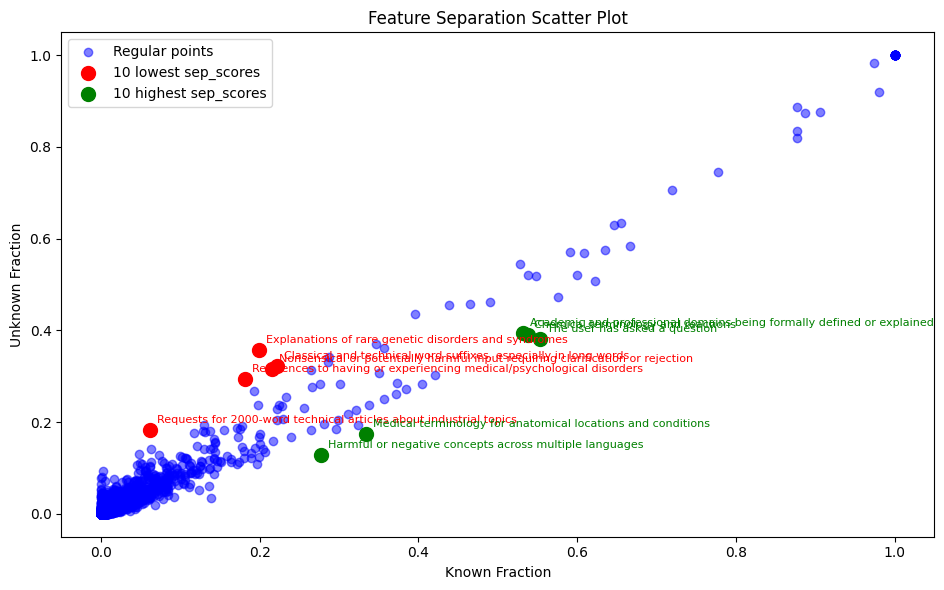

In [37]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

# Plot all points in blue
plt.scatter(feature_separations['known_frac'], 
           feature_separations['unknown_frac'], 
           alpha=0.5, 
           color='blue', 
           label='Regular points')

# Get indices of top 10 lowest and highest sep_scores
lowest_scores_idx = feature_separations['sep_score'].nsmallest(5).index
highest_scores_idx = feature_separations['sep_score'].nlargest(5).index

# Highlight lowest scores in red
plt.scatter(feature_separations.loc[lowest_scores_idx, 'known_frac'],
           feature_separations.loc[lowest_scores_idx, 'unknown_frac'],
           color='red',
           s=100,
           label='10 lowest sep_scores')

# Highlight highest scores in green
plt.scatter(feature_separations.loc[highest_scores_idx, 'known_frac'],
           feature_separations.loc[highest_scores_idx, 'unknown_frac'],
           color='green',
           s=100,
           label='10 highest sep_scores')

plt.xlabel('Known Fraction')
plt.ylabel('Unknown Fraction')
plt.title('Feature Separation Scatter Plot')
plt.legend()

# Add label annotations for both sets of highlighted points
for idx in lowest_scores_idx:

    plt.annotate(feature_separations.loc[idx, 'label'],
                (feature_separations.loc[idx, 'known_frac'],
                 feature_separations.loc[idx, 'unknown_frac']),
                xytext=(5, 5), textcoords='offset points',
                color='red', fontsize=8)

for idx in highest_scores_idx:
    plt.annotate(feature_separations.loc[idx, 'label'],
                (feature_separations.loc[idx, 'known_frac'],
                 feature_separations.loc[idx, 'unknown_frac']),
                xytext=(5, 5), textcoords='offset points',
                color='green', fontsize=8)

plt.tight_layout()
plt.show()